In [203]:
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def time_grid(N, interval=(0.0, 2.0)):
    t0, T = interval
    dt = (T - t0) / N
    t = np.linspace(t0, T, N+1)
    return dt, t

def wiener_process(N, dim=4, interval=(0.0, 2.0), seed=None):
    np.random.seed(seed)
    dt, t = time_grid(N, interval)
    dW = np.sqrt(dt) * np.random.normal(size=(N, dim))
    return dt, t, dW

def ito_integrals(dW, h, m=4):
    N = len(dW)
    I1 = np.zeros((N, m+1))  # I1[:, j] = ∫dW_j
    I2 = np.zeros((N, m+1, m+1))  # I2[:, j, k] = ∫∫dW_j dW_k
    
    I1[:, 1:] = dW  # I1[:, j] = ΔW_j
    
    for j in range(1, m+1):
        for k in range(1, m+1):
            if j == k:
                I2[:, j, k] = 0.5 * (dW[:, j-1]**2 - h)  # Ито: I(j,j) = (ΔW_j^2 - h)/2
            else:
                zeta = np.random.normal(0, 1, N)
                I2[:, j, k] = 0.5 * (dW[:, j-1] * dW[:, k-1] - h * zeta / np.sqrt(3))  # Аппроксимация
    return I1, I2

In [205]:
def s_rockd1(f, g, y0, tau, N, m=4, interval=(0.0, 2.0), seed=None):
    dt, t, dW = wiener_process(N, m, interval, seed)
    h = dt
    M = int(np.ceil(tau / h))  # Число шагов для запаздывания
    
    # Инициализация истории
    y = np.zeros(N+1)
    t_history = np.linspace(-tau, 0, M+1)
    y[:M+1] = y0(t_history)  # Заполнение начальной истории

    s = 3  # Число стадий
    eta1 = 4.3
    omega0 = 1 + eta1 / s**2
    Ts = Chebyshev.basis(s)
    omega1 = Ts(omega0) / Ts.deriv()(omega0)
    # Предварительно вычисляем T_j(omega0) для всех j
    T = np.zeros(s+1)
    T[0], T[1] = 1.0, omega0
    for j in range(2, s+1):
        T[j] = 2 * omega0 * T[j-1] - T[j-2]    
    # Инициализация истории
    y = np.zeros(N+1)
    t_history = np.linspace(-tau, 0, M+1)
    y[:M+1] = y0(t_history)  # Заполнение начальной истории

    s = 3  # Число стадий
    eta1 = 4.3
    omega0 = 1 + eta1 / s**2
    Ts = Chebyshev.basis(s)
    omega1 = Ts(omega0) / Ts.deriv()(omega0)
    # Предварительно вычисляем T_j(omega0) для всех j
    T = np.zeros(s+1)
    T[0], T[1] = 1.0, omega0
    for j in range(2, s+1):
        T[j] = 2 * omega0 * T[j-1] - T[j-2]
        
    B = np.array([[0, 0, 0], [1, 0, 0], [-1, 0, 0]])  # Параметры B
    beta1 = np.array([1, 0, 0])  # Параметры β1
    beta2 = np.array([0, 0.5, -0.5])  # Параметры β2
    I1, I2 = ito_integrals(dW, h, m)
    
    H_history = [np.zeros((m, s)) for _ in range(N+1)]  # H_history[n][j, i] = H[j, i] на шаге
    for n in range(N):
        delay_idx = n - M
        y_delay = y[delay_idx] if delay_idx >= 0 else y0(t[n] - tau)

        # Детерминированные стадии (K_i)
        K = np.zeros(s+1)
        K[0] = y[n]
        fK0 = f(t[n],K[0])
        
        K[1] = K[0] + h * (omega1 / omega0) * fK0
        fK1 = f(t[n],K[1])
        
        for i in range(2, s+1):
            K[i] = 2 * (T[i-1]/T[i])*(h * omega1 * f(t[n],K[i-1]) + omega0 * K[i-1]) - (T[i-1]/T[i])*K[i-2]
            
        H = np.zeros((m, s))
        for j in range(m):
            for i in range(s):
                sum_stoch = 0
                i += 1
                for k in range (i-1):
                    for l in range(m):
                        H_delay = H_history[delay_idx][l, i-1] if delay_idx >= 0 else y0(t[n] - tau)
                        gl = g(t[n],H[l,i-1], H_delay)[l] # g_l(y(t), y(t-τ)) → g_l(K_i(t), K_i(t-τ))
                        sum_stoch += B[i-1, k]*gl(t[n],H[l,i-1], H_delay) * I2[n, l+1, j+1] / np.sqrt(h)
                H[j, i-1] = y[n] + sum_stoch
        H_history[n] = H.copy()
        # Обновление решения
        y[n+1] = K[s]
        stoch_term = 0
        for i in range(s):
            for j in range(m):
                H_delay = H_history[delay_idx][j, i] if delay_idx >= 0 else y0(t[n] - tau)
                gj = g(t[n],H[j,i], H_delay)[j]
                stoch_term += beta1[i] * gj(t[n],H[j, i], H_delay) * I1[n, j+1]  # ΔW_j
                stoch_term += beta2[i] * gj(t[n],H[j, i], H_delay) * np.sqrt(h)  # √h·ζ (используем H_delay!)
        y[n+1] += stoch_term
    return t, y

In [207]:
def reference_solution(T=2, N=10000, delay=1.0):
    t_values = np.linspace(0, T, N + 1)
    dt = T / N
    X = np.zeros(N + 1)

    def history(t):
        return 1.0

    delays = []
    for t in t_values:
        if t <= delay:
            delays.append(history(t - delay))
        else:
            delays.append(np.interp(t - delay, t_values, X))

    delays = np.array(delays)
    dim = 4
    dW = np.sqrt(dt) * np.random.normal(size=(N, dim))
    
    X[0] = history(0)
    for n in range(N):
        t_n = t_values[n]
        X_n = X[n]
        delay_n = delays[n]
        X[n + 1] = X_n + f(t_n, X_n) * dt
        for l in range(4):
            gl = g(t_n,X_n, delay_n)[l]
            W_inc = dW[n][l]
            X[n + 1] += gl(t_n,X_n, delay_n) * W_inc

    return interp1d(t_values, X)

In [209]:
def f(t, x):
    return -2.0*x  # Детерминированная часть

def g(t, x, xd):
    return [lambda t,x, xd: 0.5*x + 0.2*xd for _ in range(4)] # Стохастическая часть с запаздыванием
    
def y0(t):
    return np.ones_like(t)  # История: y(t) = 1 при t ∈ [-τ, 0]

In [211]:
def compute_errors(ref_sol, resolutions=[50, 100, 200, 400], T=2, delay=1.0):
    strong_errors = []
    weak_errors = []
    steps = []

    for N in resolutions:
        t, X = s_rockd1(f, g, y0, tau=1.0, N=N, m=4, interval=(0.0, 2.0), seed=None)
        X_ref = ref_sol(t)
        error_strong = np.mean(np.abs(X - X_ref))
        error_weak = np.abs(np.mean(X) - np.mean(X_ref))
        strong_errors.append(error_strong)
        weak_errors.append(error_weak)
        steps.append(T / N)

    return steps, strong_errors, weak_errors

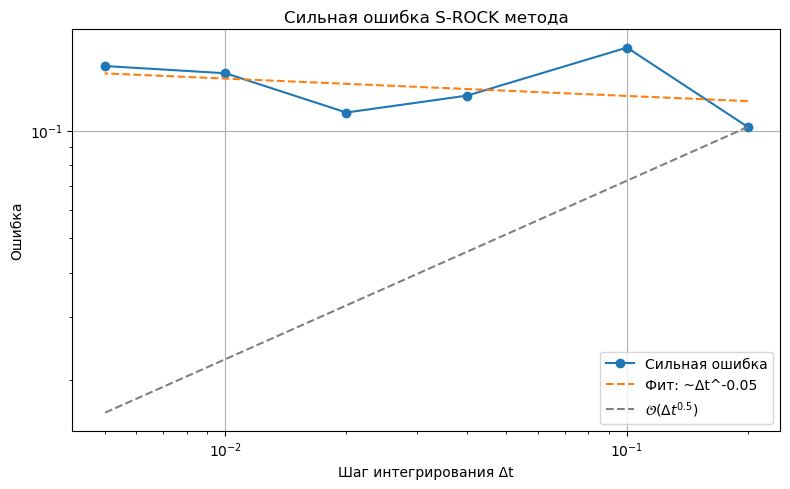

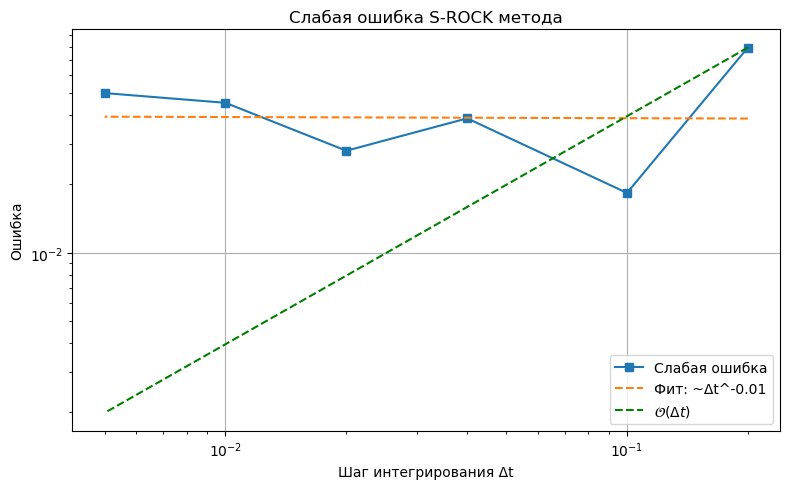

In [217]:
if __name__ == "__main__":
    # Генерация эталонного решения
    ref_sol = reference_solution()

    # Расчёты ошибок
    resolutions = [10, 20, 50, 100, 200, 400]
    steps, strong_errors, weak_errors = compute_errors(ref_sol, resolutions=resolutions)

    # --- График сильной ошибки ---
    plt.figure(figsize=(8, 5))
    plt.loglog(steps, strong_errors, 'o-', label='Сильная ошибка')
    coeffs = np.polyfit(np.log(steps), np.log(strong_errors), 1)
    plt.loglog(steps, np.exp(coeffs[1]) * np.array(steps)**coeffs[0], '--', label=f'Фит: ~Δt^{coeffs[0]:.2f}')
    plt.loglog(steps, strong_errors[0] * (np.array(steps)/steps[0])**0.5, '--', color='gray', label=r'$\mathcal{O}(\Delta t^{0.5})$')
    plt.xlabel('Шаг интегрирования Δt')
    plt.ylabel('Ошибка')
    plt.title('Сильная ошибка S-ROCK метода')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- График слабой ошибки ---
    plt.figure(figsize=(8, 5))
    plt.loglog(steps, weak_errors, 's-', label='Слабая ошибка')
    coeffs_weak = np.polyfit(np.log(steps), np.log(weak_errors), 1)
    plt.loglog(steps, np.exp(coeffs_weak[1]) * np.array(steps)**coeffs_weak[0], '--', label=f'Фит: ~Δt^{coeffs_weak[0]:.2f}')
    plt.loglog(steps, weak_errors[0] * (np.array(steps)/steps[0])**1.0, '--', color='green', label=r'$\mathcal{O}(\Delta t)$')
    plt.xlabel('Шаг интегрирования Δt')
    plt.ylabel('Ошибка')
    plt.title('Слабая ошибка S-ROCK метода')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

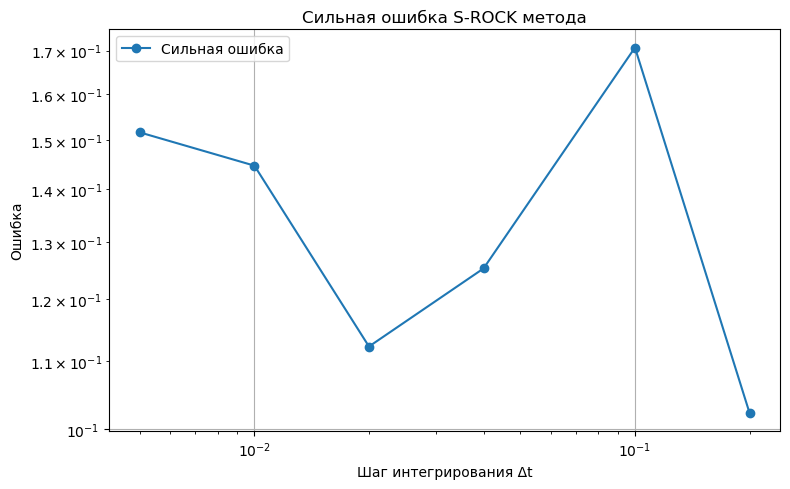

In [223]:
    # --- График сильной ошибки ---
    plt.figure(figsize=(8, 5))
    plt.loglog(steps, strong_errors, 'o-', label='Сильная ошибка')
    plt.xlabel('Шаг интегрирования Δt')
    plt.ylabel('Ошибка')
    plt.title('Сильная ошибка S-ROCK метода')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()